## EDA Player Time-Series at Chabot

### Objective

* Preliminary analysis of time-series data at Chabot

### Rationale

* Why This?  Before deploying predtive models, we need to understand what the time-series data really looks like.  Chabot is a good choice because we have long-term weather data acros all times of year, and a fairly consistent set of players.

* Why Me?  I will be building the predictive scoring model, so I need to be most familiar with the data

* Why Now?  Understanding the data better now will speed up model selection later.  

### Requirements

* numpy 1.16.4
* pandas 0.24.2
* statsmodels 0.10.0
* matplotlib 3.1.0

### Input / Output

* Input files are in the `'csv_files` directory of the project root directory (same level as `models`).  The notebook is expected to be in `models/noetbooks/eda`.  Output files will be stored in `models/score_model_data/eda`

* The input files are named via data index as follows: `Chabot_{mm}-{dd}-{yyyy}.csv` 

* Output file names ...

### Set-Up and Import

In [82]:
import numpy as np
import pandas as pd
import statsmodels as sm
import matplotlib.pyplot as plt
from pandas.plotting import autocorrelation_plot as pd_acf_plot
from statsmodels.tsa.stattools import adfuller

In [3]:
import re
import glob
import datetime as dt

In [28]:
def extract_datetime_from_Chabot_filename (filename: str):
    """Given a filename that is expected to refer to a csv file with Lake Chabot Golf Course disc golf scores, 
    return a datetime object with the estimated starting date & time.  Uses hard coded knowledge of Chabot disc golf practices
    for start time.  Returns Jan 1, 1900 for date if date parsing fails."""
    
    # Lake Chabot uses a rolling start from 8AM - 2PM year-round
    start_time = dt.time(8,0,0)
    # Filename format "[parent_dirs][/\]Chabot_mm-dd-yyyy.csv"
    # Remove any parent directories first
    filename = re.split(r'[/\\]',filename)[-1]
    date_portion_of_name = filename.split('.')[0].split('_')[1]
    nums_in_date = date_portion_of_name.split('-')
    try:
        month_num = int(nums_in_date[0])
        day_num = int(nums_in_date[1])
        year_num = int(nums_in_date[2])
    except ValueError:
        month_num = 1
        day_num = 1
        year_num = 1900
    
    extracted_date = dt.date(year_num, month_num, day_num)
    
    return dt.datetime.combine(extracted_date, start_time)

In [38]:
def parse_Chabot_input_to_df (filename : str):
    """Given an input filename that is expected to refer to a csv file with Lake Chabot Golf Course disc golf scores,
    return a Pandas dataframe with starting time, player name, raw score, handicap, and adjusted score"""
    
    try:
        input_df = pd.read_csv(filename, header=1, index_col=None, usecols=['Name','Raw','Handicap','Adjusted'],
                         skip_blank_lines=True)
    except ValueError as e:
        print(f'\nError parsing data from {filename}')
        print(e)
        return None 
    # Remove any lines without a number in 'Raw' by first coercing conversion of non-numbers to NaN
    input_df.Raw = pd.to_numeric(input_df.Raw, errors='coerce')
    input_df = input_df.dropna(subset=['Raw'])
    if len(input_df) == 0:
        print(f'\nNo useable data found in {filename}')
        return None
    datetime_obj = extract_datetime_from_Chabot_filename(filename)
    input_df['time'] = datetime_obj
    return input_df

In [44]:
# Build a master dataframe by combining all data from input files
master_df = pd.DataFrame()
print('Extracting files...',end='')
for file_to_read in glob.glob('../../../csv_files/Chabot_*.csv'):
    master_df = master_df.append(parse_Chabot_input_to_df(file_to_read))
    print('+',end='')
print(f'\n{len(master_df)} rows created.')
master_df.head()

Extracting files...+++++++++++++++++++++++++
580 rows created.


,Name,Raw,Handicap,Adjusted,time
1,Mark Shannon,61.0,-12.4,48.6,2019-01-19 08:00:00
2,Jacob Kermish-Wells,60.0,-10.72,49.28,2019-01-19 08:00:00
3,Luiz Celeste,55.0,-5.23,49.77,2019-01-19 08:00:00
4,Tu Tran,59.0,-9.07,49.93,2019-01-19 08:00:00
5,Matty Angell,53.0,-1.5,51.5,2019-01-19 08:00:00


In [48]:
# To clean up, remove any raw score of 0 or negative.
master_df = master_df[master_df.Raw > 0]
len(master_df)

562

### Explore input data

In [49]:
master_df.Name.nunique()

212

In [54]:
master_df.Name.value_counts().head(30)

Luiz Celeste            17
Dennis Warsen           16
Toby Parks              16
Scott Riley             15
Jon Braidman            13
Bob McGarity            13
Case Conover            12
Joe Kestler             10
Steve Willis             9
Gonzalo Arestizabal      9
Arthur Coddington        9
Dylan Cantu              8
Bob Montes               7
Matty Angell             7
Tu Tran                  7
Jesse Miller             7
Jacob Kermish-Wells      7
Eric Kraszewski          6
Matt Hansen              6
David Falzone            6
Nate Stone               6
John Jennings            6
Mark Farr                6
Peter William Sontag     6
Marc Atkinson            6
Jeff Fiedler             6
Christian Eck            5
Eugene Gershtein         5
Peter Sontag             5
Bryan Hesterman          4
Name: Name, dtype: int64

It looks like 6 or more games is a nice cut-off, as that will provide 26 players to analyze.

### Create Individual Time Series

In [59]:
# Create a list of the most frequent players for analysis.  The top 26 players have played 6 or more games (see above)
player_freq = master_df.Name.value_counts().head(26)
player_freq.index

Index(['Luiz Celeste', 'Dennis Warsen', 'Toby Parks', 'Scott Riley',
       'Jon Braidman', 'Bob McGarity', 'Case Conover', 'Joe Kestler',
       'Steve Willis', 'Gonzalo Arestizabal', 'Arthur Coddington',
       'Dylan Cantu', 'Bob Montes', 'Matty Angell', 'Tu Tran', 'Jesse Miller',
       'Jacob Kermish-Wells', 'Eric Kraszewski', 'Matt Hansen',
       'David Falzone', 'Nate Stone', 'John Jennings', 'Mark Farr',
       'Peter William Sontag', 'Marc Atkinson', 'Jeff Fiedler'],
      dtype='object')

In [98]:
# Build a list of DataFrames to do time-series analysis on, each one filtered by name, including all 26 frequent players
player_ts_list = [master_df[master_df.Name == frequent_player] for frequent_player in player_freq.index]
# Need to explicity provide list index value in order to set each DataFrame's index to time (too many indexes, sorry!)
for ix in range(len(player_ts_list)):
    player_ts_list[ix] = player_ts_list[ix].set_index('time').sort_values(by='time')
print(f'List of {len(player_ts_list)} DataFrames created')
player_ts_list[0].head()

List of 26 DataFrames created


,Name,Raw,Handicap,Adjusted
time,,,,
2017-10-07 08:00:00,Luiz Celeste,60.0,Establishing,Establishing
2017-10-14 08:00:00,Luiz Celeste,63.0,Establishing,Establishing
2017-10-21 08:00:00,Luiz Celeste,62.0,-6,56
2017-11-11 08:00:00,Luiz Celeste,57.0,-6.133333333,50.86666667
2017-11-25 08:00:00,Luiz Celeste,60.0,-5.2,54.8


### Time-series correlation analysis

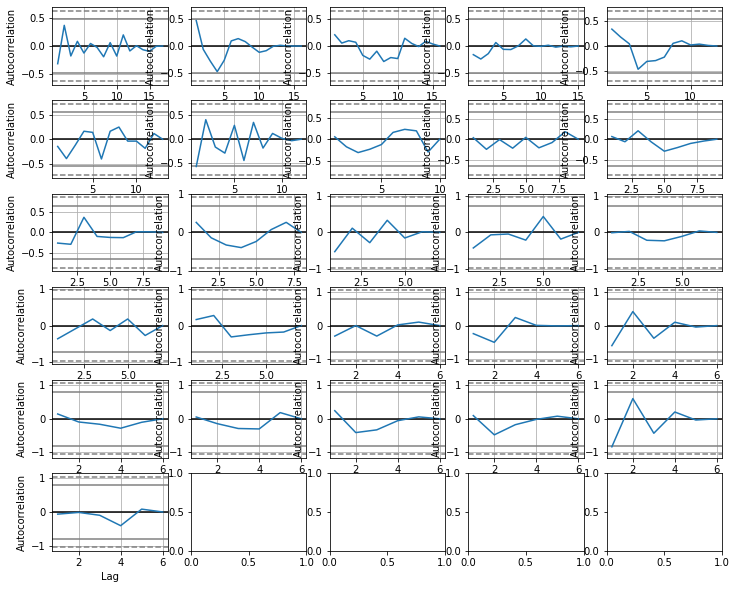

In [99]:
fig, axes = plt.subplots(nrows=6, ncols=5, figsize = (12,10))
for ix, df in enumerate(player_ts_list):
    row = ix // 5 
    col = ix % 5 
    pd_acf_plot(df.Raw, ax=axes[row,col])

* No significant correlations appear to exist for the vast majority of players.  No need for higher order AR for sure.

(array([1., 3., 3., 3., 3., 4., 3., 4., 1., 1.]),
 array([-0.87163947, -0.71241785, -0.55319624, -0.39397462, -0.234753  ,
        -0.07553139,  0.08369023,  0.24291184,  0.40213346,  0.56135508,
         0.72057669]),
 <a list of 10 Patch objects>)

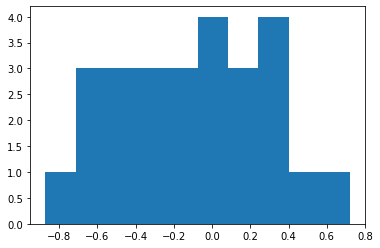

In [100]:
lag_1_list = [df.Raw.autocorr(lag=1) for df in player_ts_list]
plt.hist(lag_1_list)

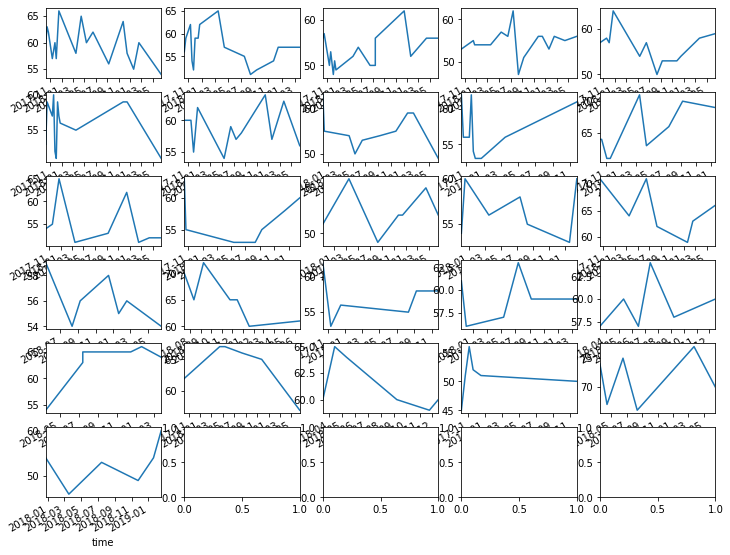

In [101]:
fig, axes = plt.subplots(nrows=6, ncols=5, figsize = (12,10))
for ix, df in enumerate(player_ts_list):
    row = ix // 5 
    col = ix % 5 
    df.Raw.plot(ax=axes[row,col])

In [102]:
def perform_dickey_fuller_test(timeseries):
    print ('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)
    return dfoutput

In [103]:
# Perform a Dickey-Fuller test on each time series ... this function prints as a side effect!
d_f_results = [perform_dickey_fuller_test(dataframe.Raw) for dataframe in player_ts_list]


Results of Dickey-Fuller Test:
Test Statistic                  1.586178
p-value                         0.997816
#Lags Used                      6.000000
Number of Observations Used    10.000000
Critical Value (1%)            -4.331573
Critical Value (5%)            -3.232950
Critical Value (10%)           -2.748700
dtype: float64
Results of Dickey-Fuller Test:
Test Statistic                 0.787782
p-value                        0.991436
#Lags Used                     6.000000
Number of Observations Used    9.000000
Critical Value (1%)           -4.473135
Critical Value (5%)           -3.289881
Critical Value (10%)          -2.772382
dtype: float64
Results of Dickey-Fuller Test:
Test Statistic                 -2.910939
p-value                         0.044091
#Lags Used                      0.000000
Number of Observations Used    15.000000
Critical Value (1%)            -3.964443
Critical Value (5%)            -3.084908
Critical Value (10%)           -2.681814
dtype: float64
Results 

dtype: float64


(array([12.,  3.,  1.,  2.,  0.,  0.,  0.,  0.,  1.,  7.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <a list of 10 Patch objects>)

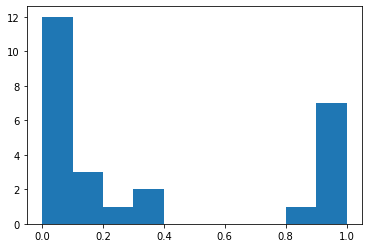

In [104]:
# Put these in an array and plot
d_f_p_values = [result[1] for result in d_f_results]
plt.hist(d_f_p_values)

* A significant number of series clearly are not stationary, so let's try differencing

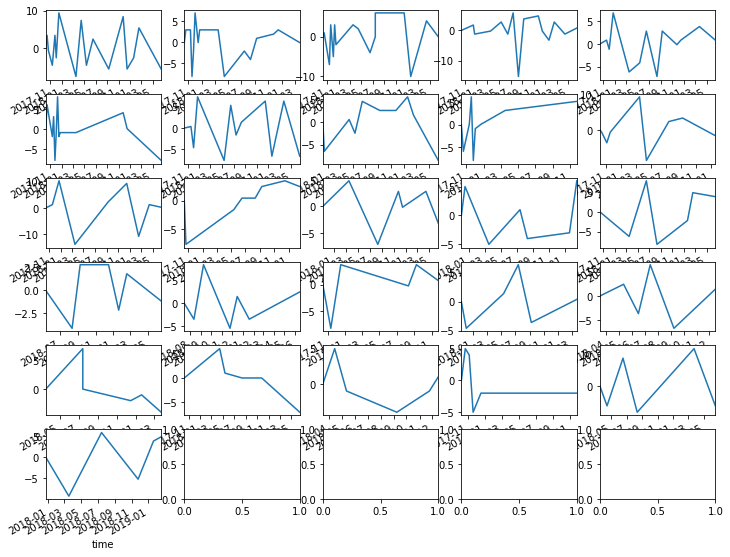

In [106]:
# Create a first-order difference and add it to the series, fill NaN's with zeros, for all dataframes
for df in player_ts_list:
    df['Raw_d1'] = df.Raw.diff(periods=1)
    mean_trend = df.Raw_d1.mean()
    df['Raw_d1_detrend'] = df.Raw_d1 - mean_trend
    df.Raw_d1_detrend = df.Raw_d1_detrend.fillna(0)

fig, axes = plt.subplots(nrows=6, ncols=5, figsize = (12,10))
for ix, df in enumerate(player_ts_list):
    row = ix // 5 
    col = ix % 5 
    df.Raw_d1_detrend.plot(ax=axes[row,col])

In [107]:
# Perform a Dickey-Fuller test on the de-trended series ... this function prints as a side effect!
d_f_results = [perform_dickey_fuller_test(dataframe.Raw_d1_detrend) for dataframe in player_ts_list]

Results of Dickey-Fuller Test:
Test Statistic                  1.214200
p-value                         0.996083
#Lags Used                      6.000000
Number of Observations Used    10.000000
Critical Value (1%)            -4.331573
Critical Value (5%)            -3.232950
Critical Value (10%)           -2.748700
dtype: float64
Results of Dickey-Fuller Test:
Test Statistic                -4.825954
p-value                        0.000048
#Lags Used                     6.000000
Number of Observations Used    9.000000
Critical Value (1%)           -4.473135
Critical Value (5%)           -3.289881
Critical Value (10%)          -2.772382
dtype: float64
Results of Dickey-Fuller Test:
Test Statistic                 -3.183805
p-value                         0.020941
#Lags Used                      2.000000
Number of Observations Used    13.000000
Critical Value (1%)            -4.068854
Critical Value (5%)            -3.127149
Critical Value (10%)           -2.701730
dtype: float64
Results 

(array([18.,  1.,  0.,  0.,  2.,  1.,  2.,  0.,  1.,  1.]),
 array([0.        , 0.09960825, 0.19921651, 0.29882476, 0.39843301,
        0.49804127, 0.59764952, 0.69725777, 0.79686603, 0.89647428,
        0.99608254]),
 <a list of 10 Patch objects>)

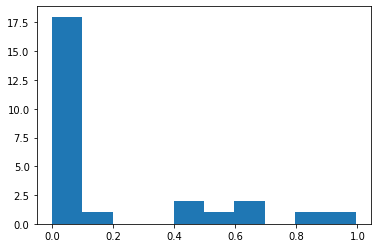

In [108]:
# Put these in an array and plot
d_f_p_values = [result[1] for result in d_f_results]
plt.hist(d_f_p_values)

* Although it helped, it only removed about 40% of the non-stationary series.  

In [97]:
player_ts_list[2]

,Name,Raw,Handicap,Adjusted,Raw_d1,Raw_d1_detrend
time,,,,,,
2019-01-19 08:00:00,Toby Parks,52.0,1.03,53.03,NaN,0.0
2018-03-17 08:00:00,Toby Parks,52.0,2.15,54.15,0.0,0.2
2019-04-13 08:00:00,Toby Parks,56.0,1.05,57.05,4.0,4.2
2018-04-14 08:00:00,Toby Parks,54.0,2.11,56.11,-2.0,-1.8
2019-06-15 08:00:00,Toby Parks,56.0,0.94,56.94,2.0,2.2
2018-06-16 08:00:00,Toby Parks,50.0,1.97,51.97,-6.0,-5.8
2018-07-14 08:00:00,Toby Parks,50.0,2.05,52.05,0.0,0.2
2018-07-14 08:00:00,Toby Parks,56.0,2.05,58.05,6.0,6.2
2017-10-07 08:00:00,Toby Parks,56.0,2.8,58.8,0.0,0.2
